Google Colab link: https://colab.research.google.com/drive/1KIAszDpVugPFyjrWiIdVLHOCSTMH8s88


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub 
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import os
import re


# Load both training and test set from Google Drive into DataFrames.
def load_dataset(path='/content/gdrive/My Drive/585/'):
  training = pd.read_csv(path + 'training_newsela.csv')
  test = pd.read_csv(path + 'test_newsela.csv')
  return training, test

In [0]:
train, test = load_dataset()

Again, it is useful to print out some stats and see a few examples from our dataset. 

In [5]:
print('Training set contains %d examples' % len(train))
print('Test set contains %d examples' % len(test))

Training set contains 8570 examples
Test set contains 953 examples


In [6]:
idx = np.random.randint(0, len(train))
print('Example from the training set:')
print('Text:' + train.iloc[idx].text)
print('Difficulty (between 0 and 4): %d' % train.iloc[idx].label) 

Example from the training set:
Text:SAN DIEGO, Calif. — Helicopter pilot Jason Thrasher was fighting a fire in California. All of a sudden, he saw what he thought was another helicopter battling the blaze.

He realized the object was a remote-controlled airplane, called a drone. It was only 10 feet from his windshield. He had to turn the helicopter sharply to avoid hitting it, according to a report.

"If that drone came through my windshield, I have no idea what could have happened," Thrasher said. If the drone hit the tail, the helicopter could have crashed.

The near-miss last September explains why firefighting pilots are worried. The problems have led to calls for more laws to keep drones away from firefighting aircraft.

Drones are also called unmanned aerial vehicles or UAVs. They are piloted by onboard computers or remotely by a person on the ground.

## Officials Suspect Drones Intruded 13 Times This Year

This year, there were 13 wildfires in which drones may have gotten in th

Load pre-trained Universal Sentence Encoder module from Tensorflow Hub.

In [0]:
hub_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

paragraph_embed = hub.KerasLayer(
    hub_url,
    dtype=tf.string
)

def build_average_model():
  model = Sequential([
    Input(shape=[], dtype=tf.string),
    paragraph_embed,
    Dense(units=256, activation=tf.nn.relu),
    Dropout(rate=0.5),
    Dense(units=256, activation=tf.nn.relu),
    Dropout(rate=0.5),
    Dense(units=5, activation='softmax')
  ])
  model.compile("adam", loss="sparse_categorical_crossentropy", metrics=['accuracy', 'mae', 'mse'])
  return model 

In [8]:
averaging_model = build_average_model()
averaging_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 256,996,229
Trainable params: 198,405
Non-trainable params: 256,797,824
____________________________________

In [9]:
from sklearn.model_selection import train_test_split


x_train, x_val, y_train, y_val = train_test_split(train.text, train.label, test_size=0.1, random_state=0)

x_train = tf.constant(x_train)
y_train = tf.constant(y_train)
x_val = tf.constant(x_val)
y_val = tf.constant(y_val)

# Early stopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=20) 

# Train our model
history = averaging_model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), callbacks=[early_stopping], batch_size=32, epochs=100)

Train on 7713 samples, validate on 857 samples
Epoch 1/100
7713/7713 [==============================] - 46s 6ms/sample - loss: 1.3275 - accuracy: 0.3800 - mae: 1.8696 - mse: 5.2042 - val_loss: 1.1002 - val_accuracy: 0.4924 - val_mae: 1.9137 - val_mse: 5.4674
Epoch 2/100
7713/7713 [==============================] - 45s 6ms/sample - loss: 1.0827 - accuracy: 0.4912 - mae: 1.8696 - mse: 5.2245 - val_loss: 1.0892 - val_accuracy: 0.4912 - val_mae: 1.9137 - val_mse: 5.4767
Epoch 3/100
7713/7713 [==============================] - 45s 6ms/sample - loss: 1.0295 - accuracy: 0.5178 - mae: 1.8696 - mse: 5.2288 - val_loss: 0.9809 - val_accuracy: 0.5438 - val_mae: 1.9137 - val_mse: 5.4789
Epoch 4/100
7713/7713 [==============================] - 45s 6ms/sample - loss: 0.9858 - accuracy: 0.5414 - mae: 1.8696 - mse: 5.2319 - val_loss: 0.9692 - val_accuracy: 0.5426 - val_mae: 1.9137 - val_mse: 5.4825
Epoch 5/100
7713/7713 [==============================] - 44s 6ms/sample - loss: 0.9426 - accuracy: 0.5632

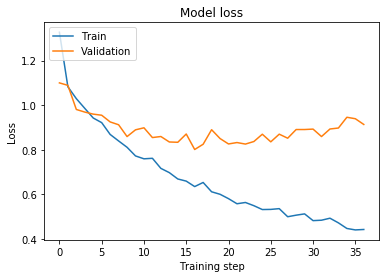

In [11]:
import matplotlib.pyplot as plt 
from google.colab import files


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Training step')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('USERank_loss.png')
# files.download('USERank_loss.png')

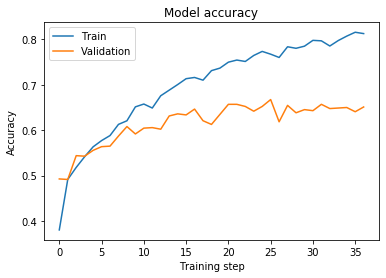

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training step')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('USERank_acc.png')
# files.download('USERank_acc.png')

In [13]:
X_test = tf.constant(test.text)
probs = averaging_model.predict(x=X_test)
predictions = np.argmax(probs, axis=1)


(953,)

In [20]:
y_test = test.label 

acc = np.mean(y_test == predictions)
print('Accuracy: {}'.format(acc))
mae = np.mean(np.abs(y_test - predictions))
print('MAE: {}'.format(mae))
mse = np.mean(np.square(y_test - predictions))
print('MSE: {}'.format(mse))

Accuracy: 0.6495278069254984
MAE: 0.36621196222455404
MSE: 0.39769150052465896
